## Plot the generated daily soil and runoff cation concentrations

In [5]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams

site = 'UC_Davis'

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18

In [6]:
flist_1 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                        'ERW_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                        f'ERW_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
            for yy in range(2014, 2018)]

# control - no treatment
flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                        'ERW_20231109_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                        f'ERW_20231109_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
            for yy in range(2018, 2023)]
hr0 = xr.open_mfdataset(flist_1 + flist_2)
tvec = pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr0['time'].values])


# treatment - metabasalt
flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                        'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                        f'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
            for yy in range(2018, 2023)]
hr = xr.open_mfdataset(flist_1 + flist_2)
tvec = pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr['time'].values])

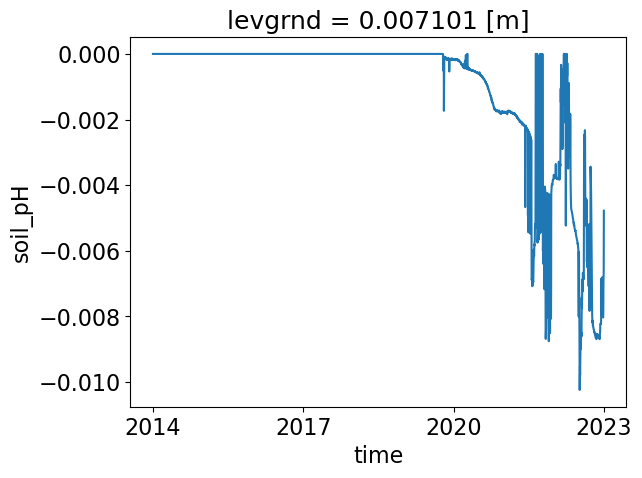

In [7]:
(hr0['soil_pH'] - hr['soil_pH'].values)[:, 0, 0].plot()

In [12]:
# Calculate bicarbonate alkalinity from soil pH
# (1) pre-treatment (pre-2019: bicarbonate alkalinity)
# (2) during-treatment (2019-autumn 2020)
# (3) post-treatment (winter 2020-2021)

zsoi = np.insert((hr['levgrnd'].values[:-1] + hr['levgrnd'].values[1:]) / 2, 0, 0)
zsoi = np.insert(zsoi, -1, hr['levgrnd'].values[-1] + 
                0.5 * (hr['levgrnd'].values[-1] - hr['levgrnd'].values[-2]))
thickness = np.diff(zsoi)

alkalinity = {
    'control': np.zeros([len(hr['time']), 2]), 
    'metabasalt': np.zeros([len(hr['time']), 2])
}

for i, mixing_depth in enumerate([0.15, 0.3]):
    weight = np.where(zsoi[:-1] < mixing_depth, np.minimum(thickness, mixing_depth - zsoi[:-1]), 0)

    # mol L-1 => normalized to CaCO3 weight to multiply by 100
    hco3 = 10**(-7.8136)*360*1e-6/10**(-hr0['soil_pH'].values[:,:,0]) * 100
    alkalinity['control'][:,i] = np.nansum(hco3 * weight.reshape(1, -1), axis = 1) / np.sum(weight)

    # mol L-1 => normalized to CaCO3 weight to multiply by 100
    hco3 = 10**(-7.8136)*360*1e-6/10**(-hr['soil_pH'].values[:,:,0]) * 100
    alkalinity['metabasalt'][:,i] = np.nansum(hco3 * weight.reshape(1, -1), axis = 1) / np.sum(weight)

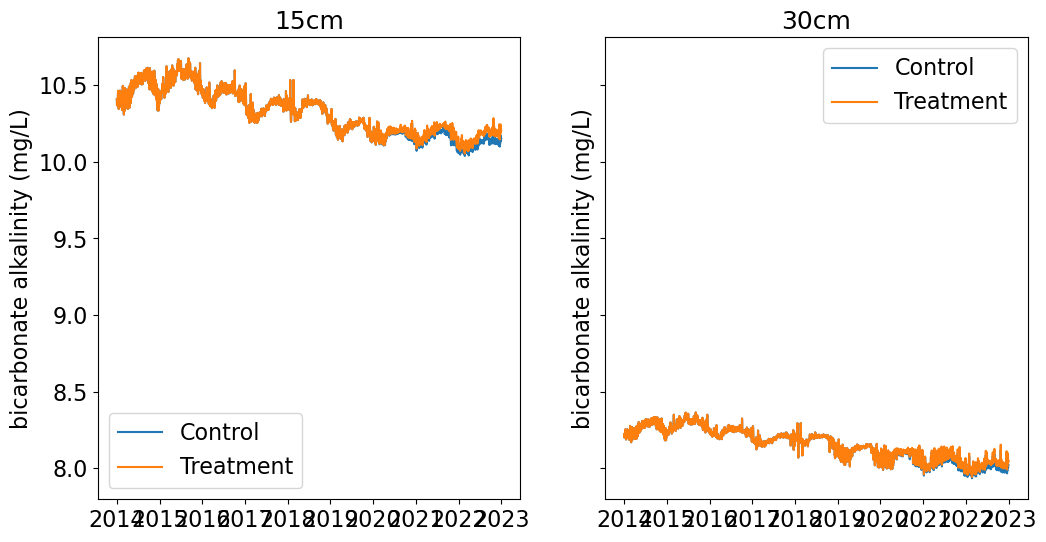

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6), sharex = True, sharey = True)
for i, (depth, ax) in enumerate(zip(['15cm','30cm'], axes.flat)):
    ax.plot(tvec, alkalinity['control'][:, i] * 1000, label = 'Control')
    ax.plot(tvec, alkalinity['metabasalt'][:, i] * 1000, label = 'Treatment')
    ax.set_title(depth)
    ax.set_ylabel('bicarbonate alkalinity (mg/L)')
    ax.legend()

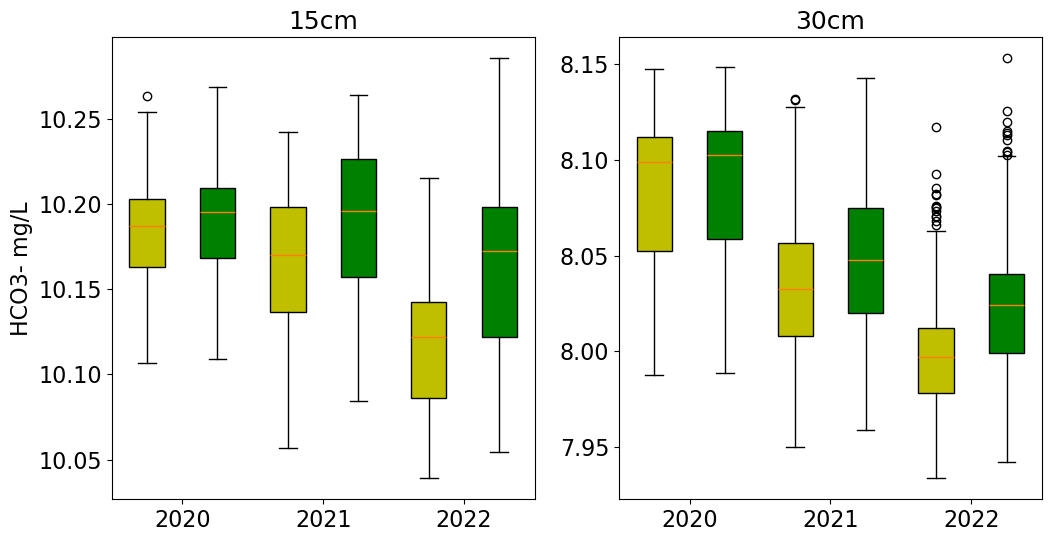

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6), sharex = True, sharey = False)
for i, (depth, ax) in enumerate(zip(['15cm','30cm'], axes.flat)):
    # alkalinity['control'][tvec.year < 2020, i] * 1000
    p1 = ax.boxplot([alkalinity['control'][tvec.year == 2020, i] * 1000, 
                     alkalinity['control'][tvec.year == 2021, i] * 1000, 
                     alkalinity['control'][tvec.year == 2022, i] * 1000],
                    positions = [2,4,6], patch_artist=True)
    for patch in p1['boxes']:
        patch.set_facecolor('y')

    # alkalinity['metabasalt'][tvec.year < 2020, i] * 1000
    p2 = ax.boxplot([alkalinity['metabasalt'][tvec.year == 2020, i] * 1000, 
                     alkalinity['metabasalt'][tvec.year == 2021, i] * 1000, 
                     alkalinity['metabasalt'][tvec.year == 2022, i] * 1000],
                    positions = [3,5,7], patch_artist=True)
    for patch in p2['boxes']:
        patch.set_facecolor('g')

    ax.set_xticks([2.5,4.5,6.5]) # 0.5,
    ax.set_xticklabels(['2020','2021','2022']) # '1980-2019',
    if i == 0:
        ax.set_ylabel('HCO3- mg/L')
    if i == 0:
        ax.set_title('15cm')
    else:
        ax.set_title('30cm')

In [44]:
total_alkalinity = {
    'control': np.zeros([len(hr['time']), 2]),
    'metabasalt': np.zeros([len(hr['time']), 2])
}
for i, (mass_cation, valence_cation) in enumerate(\
    zip([40, 24, 23, 29, 27], [2, 2, 1, 1, 3]), 1):
    for j, mixing_depth in enumerate([0.15, 0.3]):
        weight = np.where(zsoi[:-1] < mixing_depth,
                          np.minimum(thickness, mixing_depth - zsoi[:-1]), 0)
        # mol/kg
        cation_conc = hr0[f'cation_vr_{i}'][:, :, 0] / mass_cation / hr0['H2OSOI'][:, :, 0] * 1e-3
        cation_conc = np.sum(cation_conc * weight.reshape(1, -1), axis = 1) / np.sum(weight)
        # multiply by valence to give HCO3- term, and convert to CaCO3 equivalent
        total_alkalinity['control'][:,j] = total_alkalinity['control'][:,j] + cation_conc * valence_cation * 100

        cation_conc = hr[f'cation_vr_{i}'][:, :, 0] / mass_cation / hr['H2OSOI'][:, :, 0] * 1e-3
        cation_conc = np.sum(cation_conc * weight.reshape(1, -1), axis = 1) / np.sum(weight)
        # multiply by valence to give HCO3- term, and convert to CaCO3 equivalent
        total_alkalinity['metabasalt'][:,j] = total_alkalinity['metabasalt'][:,j] + cation_conc * valence_cation * 100

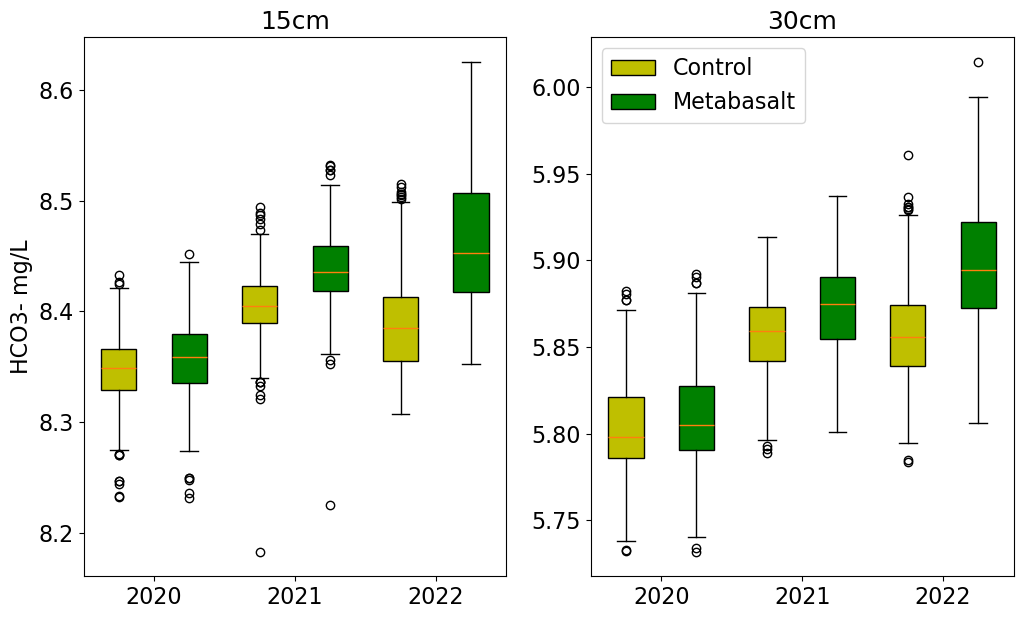

In [61]:
fig, axes = plt.subplots(1, 2, figsize = (12, 7), sharex = True, sharey = False)
for i, (depth, ax) in enumerate(zip(['15cm','30cm'], axes.flat)):
    # alkalinity['control'][tvec.year < 2020, i] * 1000
    p1 = ax.boxplot([total_alkalinity['control'][tvec.year == 2020, i] * 1000, 
                     total_alkalinity['control'][tvec.year == 2021, i] * 1000, 
                     total_alkalinity['control'][tvec.year == 2022, i] * 1000],
                    positions = [2,4,6], patch_artist=True)
    for patch in p1['boxes']:
        patch.set_facecolor('y')

    # alkalinity['metabasalt'][tvec.year < 2020, i] * 1000
    p2 = ax.boxplot([total_alkalinity['metabasalt'][tvec.year == 2020, i] * 1000, 
                     total_alkalinity['metabasalt'][tvec.year == 2021, i] * 1000, 
                     total_alkalinity['metabasalt'][tvec.year == 2022, i] * 1000],
                    positions = [3,5,7], patch_artist=True)
    for patch in p2['boxes']:
        patch.set_facecolor('g')

    ax.set_xticks([2.5,4.5,6.5]) # 0.5,
    ax.set_xticklabels(['2020','2021','2022']) # '1980-2019',
    if i == 0:
        ax.set_ylabel('HCO3- mg/L')
    if i == 0:
        ax.set_title('15cm')
    else:
        ax.set_title('30cm')
ax.legend([p1['boxes'][0], p2['boxes'][0]], ['Control', 'Metabasalt'])

In [11]:
hr.close()